In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn

In [4]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/generated_data.csv')

In [5]:
display(data_frame.head(5))

,Y,U
0,0.000000,-0.396405
1,0.000000,0.420230
2,-0.478943,-0.478943
3,-0.208101,-0.208101
4,-0.084918,-0.311100


In [9]:
# Defining a batch size based on the data
batch_size = 100

# Split the dataset into different batches
batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))

# Shifting batch number 5 to the end to be used as a test data
batch_data.append(batch_data.pop(1))

# Combining all the batches to form a single dataset
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))

In [10]:
batch_data

[           Y         U
 0   0.000000 -0.396405
 1   0.000000  0.420230
 2  -0.478943 -0.478943
 3  -0.208101 -0.208101
 4  -0.084918 -0.311100
 ..       ...       ...
 95  0.277987 -0.082640
 96 -0.145947  0.054461
 97 -0.913434 -0.818083
 98  0.721932  0.514115
 99 -0.977684  0.503064
 
 [100 rows x 2 columns],
             Y         U
 200  1.504574  0.445409
 201  0.892548 -0.831160
 202  0.586097 -1.039030
 203  1.311933  0.044401
 204  1.885182  0.043174
 ..        ...       ...
 295  0.072027  0.225547
 296  0.505857  0.434251
 297  0.099564 -0.009810
 298 -0.668682 -0.799278
 299 -1.398985 -1.277600
 
 [100 rows x 2 columns],
             Y         U
 300  1.332716  0.783431
 301 -1.861193 -0.264761
 302  0.001567  0.223098
 303 -0.128586 -0.121290
 304 -1.093283 -1.092805
 ..        ...       ...
 395  1.169672 -0.562275
 396  2.487172  0.705158
 397  1.466187 -0.066953
 398  0.261220 -0.750334
 399  0.646450 -0.275807
 
 [100 rows x 2 columns],
             Y         U
 100 -

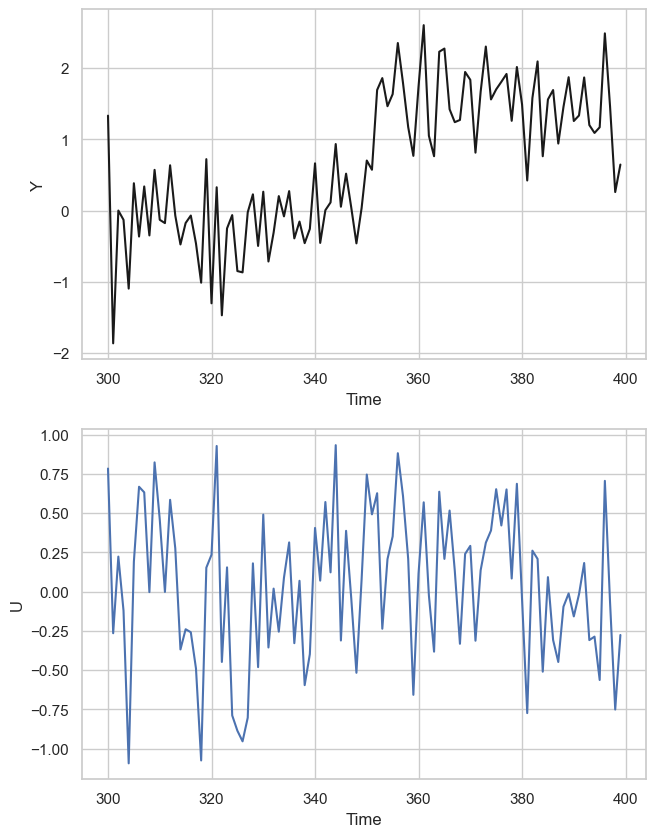

In [13]:
# Plotting the test data batch
fig = plt.figure(figsize=(16,10))

batch_no = 3

plt.subplot(2, 2, 1)
plt.plot(batch_data[batch_no-1]['Y'],'k')
plt.xlabel('Time')
plt.ylabel('Y')


plt.subplot(2, 2, 3)
plt.plot(batch_data[batch_no-1]['U'],'b')
plt.xlabel('Time')
plt.ylabel('U')


plt.show()

In [15]:
# Define a test size
test_size = batch_size

y = df.values.astype(float)

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

# Convert train set into a torch tensor
train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])

In [16]:
# Creating a function to generate the input data for the lstm 
def input_data(seq,ws):
    
    inp_data = []
    
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+101]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:2]

            inp_data.append((window,label))
        
    return inp_data

In [17]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

In [18]:
from classy import LSTMModel

# Creating a model instance, loss function and the optimizer
model = LSTMModel(input_size=2,hidden_size_1=50,hidden_size_2=50,out_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 50)
  (lstm_2): LSTM(50, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [20]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [22]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 10000
   200
   200
 10000
 10000
   200
   200
    50
     1
______
 31251


In [23]:
# Set the number of epochs

epochs = 100

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,1400,100):
    
        for seq,label in train_data[bat:bat+100]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            
            # initialize the hidden states

            model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                            torch.zeros(1,1,model.hidden_size_1))

            model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                            torch.zeros(1,1,model.hidden_size_2))
            
            # Make predictions on the current sequence

            y_pred = model(seq)
            
            # Compute the loss

            loss = criterion(y_pred, label)
            
            # Perform back propogation and gradient descent

            loss.backward()

            optimizer.step()

    if epoch%10 == 0:

        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')

/opt/anaconda3/envs/rnn4nds/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.28417066
Epoch: 10 Loss: 0.29232132
Epoch: 20 Loss: 0.28164351
Epoch: 30 Loss: 0.25919950
Epoch: 40 Loss: 0.23376745
Epoch: 50 Loss: 0.21990803
Epoch: 60 Loss: 0.21813118
Epoch: 70 Loss: 0.22148411
Epoch: 80 Loss: 0.22778088
Epoch: 90 Loss: 0.23732129


In [42]:
future = 100

# Set the model to evaluation mode

model.eval()

preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:1])
print(preds)
for i in range(future-1):
    
    seq = test_set[i].reshape(-1,2)
    
    # Informing PyTorch that I am no longer interested in the gradients
    
    with torch.no_grad():
        
        # Initialize the hidden states
        
        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        
        preds.append(model(seq))
print(preds)       

tensor([-1.4924])
[tensor([[-1.4924]])]
[tensor([[-1.4924]]), tensor([[0.0092]]), tensor([[0.3588]]), tensor([[0.2887]]), tensor([[-0.0452]]), tensor([[0.6292]]), tensor([[0.1754]]), tensor([[-0.0346]]), tensor([[0.1023]]), tensor([[-0.0282]]), tensor([[-0.0928]]), tensor([[-0.0344]]), tensor([[0.0290]]), tensor([[0.1417]]), tensor([[0.0413]]), tensor([[-0.0308]]), tensor([[-0.0643]]), tensor([[0.0772]]), tensor([[-0.0161]]), tensor([[0.0641]]), tensor([[0.5667]]), tensor([[0.1434]]), tensor([[-0.0856]]), tensor([[0.4887]]), tensor([[0.0558]]), tensor([[-0.1149]]), tensor([[0.7572]]), tensor([[0.0230]]), tensor([[-0.0903]]), tensor([[0.8655]]), tensor([[0.0602]]), tensor([[0.0037]]), tensor([[0.7357]]), tensor([[0.1626]]), tensor([[0.1742]]), tensor([[0.2374]]), tensor([[0.1682]]), tensor([[0.2885]]), tensor([[-0.2175]]), tensor([[0.2439]]), tensor([[0.1246]]), tensor([[0.1048]]), tensor([[0.1990]]), tensor([[0.0870]]), tensor([[0.9261]]), tensor([[0.9334]]), tensor([[0.6347]]), tensor

In [43]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:2])

Text(0, 0.5, 'x1')

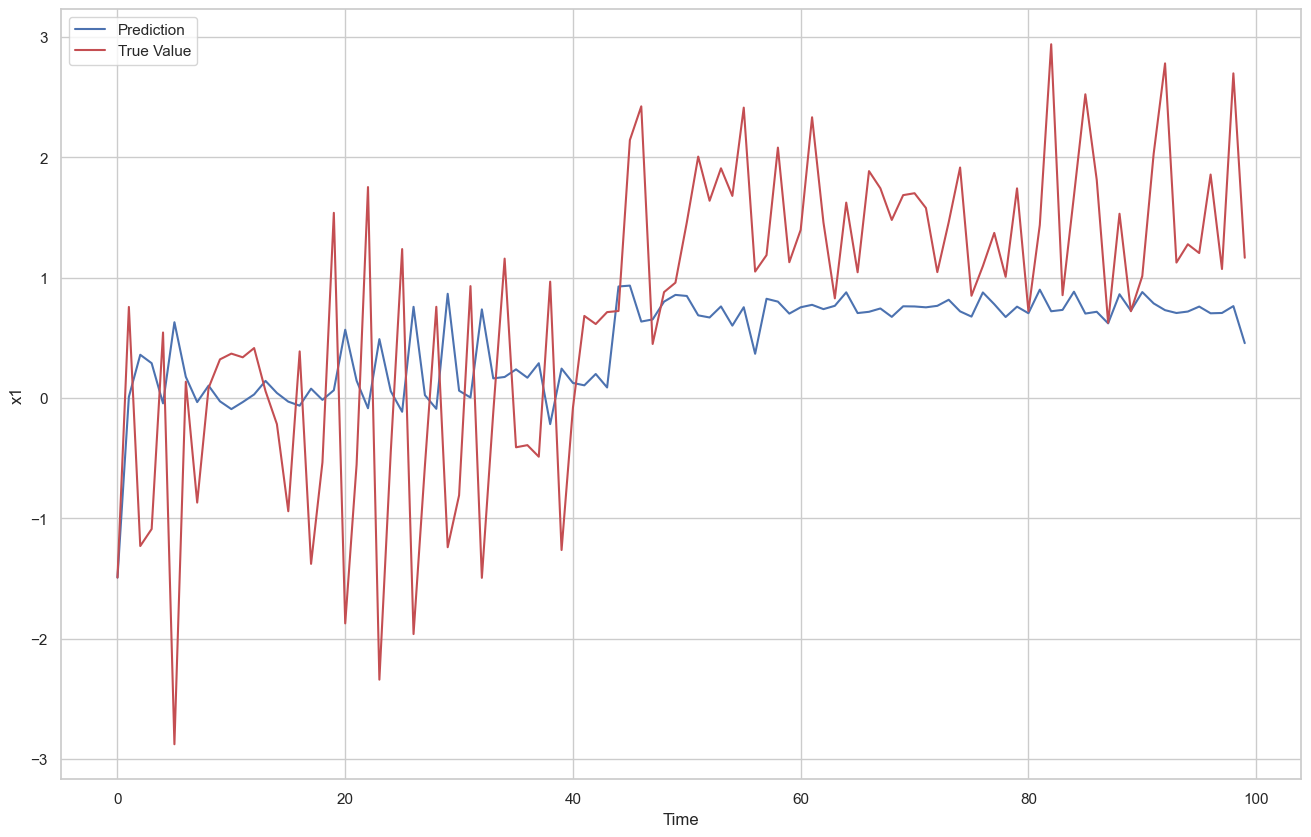

In [44]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [55]:
RMSE = np.sqrt(np.sum(np.square((predictions - true_values[:,0])))/predictions.size)
display(RMSE)

12.865164629242022